---
title: "Practice Activity 8.1"
format:
  html:
    embed-resources: true
    code-fold: true
execute:
  echo: true
  warning: false
  message: false
---

# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [1]:
!pip install palmerpenguins

In [2]:
# Code Here
import palmerpenguins as pg
import pandas as pd
df = pg.load_penguins()
df.head()


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [3]:

df_dummy = pd.get_dummies(df)
df_cleaned = df_dummy.dropna()
df_cleaned.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_female,sex_male
0,39.1,18.7,181.0,3750.0,2007,True,False,False,False,False,True,False,True
1,39.5,17.4,186.0,3800.0,2007,True,False,False,False,False,True,True,False
2,40.3,18.0,195.0,3250.0,2007,True,False,False,False,False,True,True,False
4,36.7,19.3,193.0,3450.0,2007,True,False,False,False,False,True,True,False
5,39.3,20.6,190.0,3650.0,2007,True,False,False,False,False,True,False,True


Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [5]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 1. Separate the target variable `bill_depth_mm` from the original `df` DataFrame
#    Ensure `X` still contains the original categorical columns.
y = df['bill_depth_mm']
X = df.drop('bill_depth_mm', axis=1)

# Drop the 'year' column as per previous notebook's implicit decision, or to simplify
# For this task, we will assume 'year' is also a feature to be used.
# X = X.drop('year', axis=1)

# 2. Identify the numerical and categorical column names in the `X` DataFrame.
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Original X head:")
print(X.head())
print("\nNumerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

# 3. Create a ColumnTransformer named preprocessor_ohe
preprocessor_ohe = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Keep other columns if any, though here it shouldn't be needed.
)

# 4. Split the X and y data into training and testing sets
#    Handle rows with NaN values in the target 'bill_depth_mm' by dropping them from X and y.
#    This ensures consistency for splitting.

# Drop rows where y is NaN to ensure consistent splitting
valid_indices = y.dropna().index
X_valid = X.loc[valid_indices]
y_valid = y.loc[valid_indices]

X_train, X_test, y_train, y_test = train_test_split(X_valid, y_valid, test_size=0.25, random_state=42)

print("\nData preparation for ColumnTransformer with OneHotEncoder complete.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Original X head:
  species     island  bill_length_mm  flipper_length_mm  body_mass_g     sex  \
0  Adelie  Torgersen            39.1              181.0       3750.0    male   
1  Adelie  Torgersen            39.5              186.0       3800.0  female   
2  Adelie  Torgersen            40.3              195.0       3250.0  female   
3  Adelie  Torgersen             NaN                NaN          NaN     NaN   
4  Adelie  Torgersen            36.7              193.0       3450.0  female   

   year  
0  2007  
1  2007  
2  2007  
3  2007  
4  2007  

Numerical columns: ['bill_length_mm', 'flipper_length_mm', 'body_mass_g', 'year']
Categorical columns: ['species', 'island', 'sex']

Data preparation for ColumnTransformer with OneHotEncoder complete.
X_train shape: (256, 7)
X_test shape: (86, 7)
y_train shape: (256,)
y_test shape: (86,)


In [8]:
from sklearn.linear_model import LinearRegression

# Create the Linear Regression pipeline
linear_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_ohe),
    ('regressor', LinearRegression())
])

# Create the kNN pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_ohe),
    ('regressor', KNeighborsRegressor())
])

# Create the Decision Tree pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_ohe),
    ('regressor', DecisionTreeRegressor())
])

print("Model pipelines updated with preprocessor_ohe.")

Model pipelines updated with preprocessor_ohe.


In [9]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids for kNN and Decision Tree pipelines
knn_param_grid_pipeline = {
    'regressor__n_neighbors': [3, 5, 7, 9, 11],
    'regressor__weights': ['uniform', 'distance']
}

dt_param_grid_pipeline = {
    'regressor__max_depth': [3, 5, 7, 9, 11],
    'regressor__min_samples_leaf': [1, 5, 10]
}

# Instantiate GridSearchCV for kNN pipeline
knn_grid_search = GridSearchCV(
    knn_pipeline,
    knn_param_grid_pipeline,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1 # Use all available cores
)

# Instantiate GridSearchCV for Decision Tree pipeline
dt_grid_search = GridSearchCV(
    dt_pipeline,
    dt_param_grid_pipeline,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1 # Use all available cores
)

# Fit the Linear Regression pipeline directly
linear_reg_pipeline.fit(X_train, y_train)
print("Linear Regression pipeline fitted.")

# Fit GridSearchCV for kNN
knn_grid_search.fit(X_train, y_train)
print("kNN GridSearchCV fitted.")

# Fit GridSearchCV for Decision Tree
dt_grid_search.fit(X_train, y_train)
print("Decision Tree GridSearchCV fitted.")

# Extract and store the best estimators
best_knn_pipeline = knn_grid_search.best_estimator_
best_dt_pipeline = dt_grid_search.best_estimator_

print(f"Best kNN parameters: {knn_grid_search.best_params_}")
print(f"Best Decision Tree parameters: {dt_grid_search.best_params_}")
print("Best kNN and Decision Tree pipelines extracted.")

Linear Regression pipeline fitted.
kNN GridSearchCV fitted.
Decision Tree GridSearchCV fitted.
Best kNN parameters: {'regressor__n_neighbors': 11, 'regressor__weights': 'distance'}
Best Decision Tree parameters: {'regressor__max_depth': 5, 'regressor__min_samples_leaf': 5}
Best kNN and Decision Tree pipelines extracted.


In [10]:
from sklearn.metrics import mean_squared_error

# --- Linear Regression Model ---
# Make predictions
y_train_pred_lr = linear_reg_pipeline.predict(X_train)
y_test_pred_lr = linear_reg_pipeline.predict(X_test)

# Calculate MSE
mse_train_lr = mean_squared_error(y_train, y_train_pred_lr)
mse_test_lr = mean_squared_error(y_test, y_test_pred_lr)

print(f"Linear Regression - Training MSE: {mse_train_lr:.4f}")
print(f"Linear Regression - Test MSE: {mse_test_lr:.4f}")

# --- kNN Model ---
# Make predictions using the best kNN pipeline
y_train_pred_knn = best_knn_pipeline.predict(X_train)
y_test_pred_knn = best_knn_pipeline.predict(X_test)

# Calculate MSE
mse_train_knn = mean_squared_error(y_train, y_train_pred_knn)
mse_test_knn = mean_squared_error(y_test, y_test_pred_knn)

print(f"\nkNN - Training MSE: {mse_train_knn:.4f}")
print(f"kNN - Test MSE: {mse_test_knn:.4f}")

# --- Decision Tree Model ---
# Make predictions using the best Decision Tree pipeline
y_train_pred_dt = best_dt_pipeline.predict(X_train)
y_test_pred_dt = best_dt_pipeline.predict(X_test)

# Calculate MSE
mse_train_dt = mean_squared_error(y_train, y_train_pred_dt)
mse_test_dt = mean_squared_error(y_test, y_test_pred_dt)

print(f"\nDecision Tree - Training MSE: {mse_train_dt:.4f}")
print(f"Decision Tree - Test MSE: {mse_test_dt:.4f}")

Linear Regression - Training MSE: 0.6053
Linear Regression - Test MSE: 0.6169

kNN - Training MSE: 0.0000
kNN - Test MSE: 0.7439

Decision Tree - Training MSE: 0.3744
Decision Tree - Test MSE: 0.8658


Oops forgot to do the other KNN

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# 1. Instantiate a new KNeighborsRegressor with n_neighbors=5 and weights='distance'
knn_regressor_k5 = KNeighborsRegressor(n_neighbors=5, weights='distance')

# 2. Create a Pipeline named knn_pipeline_k5
knn_pipeline_k5 = Pipeline(steps=[
    ('preprocessor', preprocessor_ohe),
    ('regressor', knn_regressor_k5)
])

# 3. Fit knn_pipeline_k5 to the training data
knn_pipeline_k5.fit(X_train, y_train)
print("kNN (k=5) pipeline fitted.")

# 4. Make predictions on training and test data
y_train_pred_knn_k5 = knn_pipeline_k5.predict(X_train)
y_test_pred_knn_k5 = knn_pipeline_k5.predict(X_test)

# 5. Calculate training MSE
mse_train_knn_k5 = mean_squared_error(y_train, y_train_pred_knn_k5)

# 6. Calculate test MSE
mse_test_knn_k5 = mean_squared_error(y_test, y_test_pred_knn_k5)

# 7. Print the calculated MSEs
print(f"\nkNN (k=5) - Training MSE: {mse_train_knn_k5:.4f}")
print(f"kNN (k=5) - Test MSE: {mse_test_knn_k5:.4f}")

kNN (k=5) pipeline fitted.

kNN (k=5) - Training MSE: 0.0000
kNN (k=5) - Test MSE: 0.8145


In [13]:
import pandas as pd

# 1. Create a dictionary to store the training and test MSE values for each model
model_errors = {
    'Linear Regression': {
        'Training MSE': mse_train_lr,
        'Test MSE': mse_test_lr
    },
    'Best kNN': {
        'Training MSE': mse_train_knn,
        'Test MSE': mse_test_knn
    },
    'kNN (k=5)': {
        'Training MSE': mse_train_knn_k5,
        'Test MSE': mse_test_knn_k5
    },
    'Decision Tree': {
        'Training MSE': mse_train_dt,
        'Test MSE': mse_test_dt
    }
}

# 2. Convert this dictionary into a Pandas DataFrame
#    Model names will automatically become the index.
error_df = pd.DataFrame(model_errors).T

print("DataFrame of Model Errors:")
print(error_df)


DataFrame of Model Errors:
                   Training MSE  Test MSE
Linear Regression      0.605302  0.616872
Best kNN               0.000000  0.743905
kNN (k=5)              0.000000  0.814480
Decision Tree          0.374354  0.865841


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 4. Reshape the DataFrame into a long format suitable for plotting with Seaborn
#    'Model' as the id_vars, and 'Error Type' and 'MSE' as var_name and value_name respectively.
error_df_long = error_df.reset_index().melt(id_vars='index', var_name='Error Type', value_name='MSE')
error_df_long = error_df_long.rename(columns={'index': 'Model'})

print("Long format DataFrame for plotting:")
print(error_df_long)


Long format DataFrame for plotting:
               Model    Error Type       MSE
0  Linear Regression  Training MSE  0.605302
1           Best kNN  Training MSE  0.000000
2          kNN (k=5)  Training MSE  0.000000
3      Decision Tree  Training MSE  0.374354
4  Linear Regression      Test MSE  0.616872
5           Best kNN      Test MSE  0.743905
6          kNN (k=5)      Test MSE  0.814480
7      Decision Tree      Test MSE  0.865841


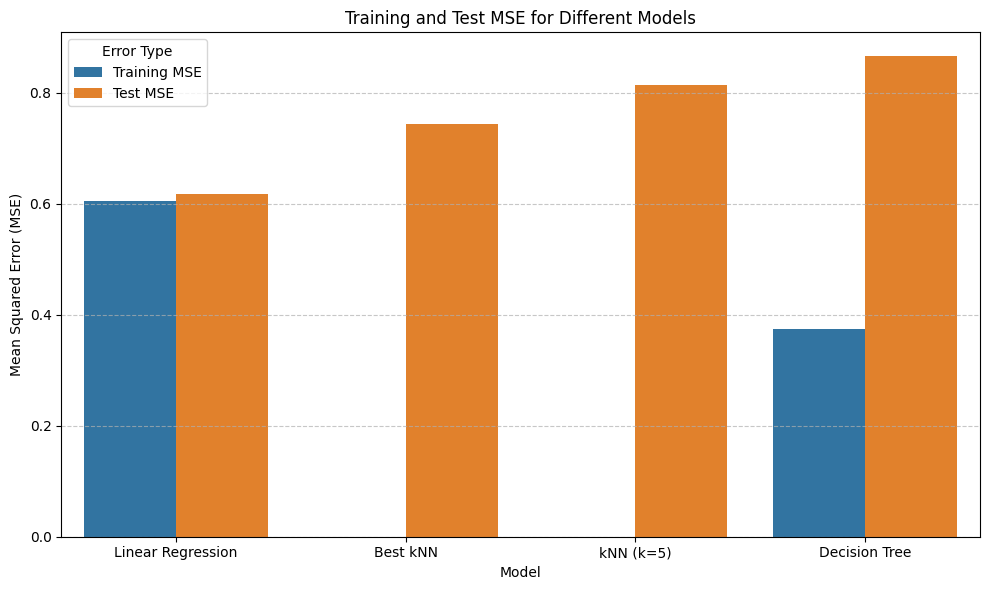

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 5. Create a bar plot using sns.barplot()
plt.figure(figsize=(10, 6)) # Adjust figure size for better readability
sns.barplot(x='Model', y='MSE', hue='Error Type', data=error_df_long)

# 6. Add appropriate labels and a title
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Test MSE for Different Models')
plt.legend(title='Error Type')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add grid for better readability

# 7. Display the plot
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


I wasn't able to figure out the other plot but I think this works well